<a href="https://colab.research.google.com/github/no1rabbit/Cloud_chasing/blob/main/NDVI_jupyternotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%matplotlib inline

# Now import TensorFlow and it will use CPU
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from math import cos
from tqdm import tqdm
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# view all the entire dataset not truncated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

2.15.0
[]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/no1rabbit/Cloud_chasing.git

fatal: destination path 'Cloud_chasing' already exists and is not an empty directory.


In [12]:
%cd "/content/Cloud_chasing"

/content/Cloud_chasing


In [13]:
# Import functions from the script file
from cloud_functions import rotate_image_and_heading, train_and_visualize

In [14]:
# Define paths to your data
gps_file = 'data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['month'] = gps_data['date1'].dt.month

gps_data = gps_data.sort_values(by=['ID','date'])

In [6]:
gps_data.head()

,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,migrant,date,x,y,sex,dailystate,year,months,mon2,season,burst_,t1_,t2_,dt_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,sp_m,date1,month
0,SW100,680764.8743,674933.7549,9724120.192,9728178.122,7104.136073,-0.431814,WB,migrant,2021-12-13,-2.497654,34.626559,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-13T07:30:00Z,2021-12-14T07:30:00Z,86400,True,3,0.908208,8.868432,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-13,12
11,SW100,674933.7549,675019.5210,9728178.122,9727439.122,743.960230,2.294312,WB,migrant,2021-12-14,-2.461019,34.574084,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-14T07:30:00Z,2021-12-15T07:30:00Z,86400,True,4,-0.662023,6.611988,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-14,12
22,SW100,675019.5210,673586.9019,9727439.122,9726742.822,1592.868851,-1.233925,WB,migrant,2021-12-15,-2.467701,34.574863,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-15T07:30:00Z,2021-12-16T07:30:00Z,86400,True,5,0.330536,7.373292,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-15,12
33,SW100,673586.9019,669799.8705,9726742.822,9723233.359,5163.132516,0.294964,WB,migrant,2021-12-16,-2.474014,34.561989,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-16T07:30:00Z,2021-12-17T07:30:00Z,86400,True,6,0.956813,8.549299,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-16,12
44,SW100,669799.8705,666982.3274,9723233.359,9716497.189,7301.680313,0.427264,WB,migrant,2021-12-17,-2.505793,34.527973,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-17T07:30:00Z,2021-12-18T07:30:00Z,86400,True,7,0.910103,8.895860,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-17,12


In [15]:
##
#ds = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
ds = xr.open_dataset('/content/drive/MyDrive/wildebeest_data/serengeti_modis_UTM_2015-2023.nc')
ds


<xarray.Dataset>
Dimensions:      (y: 1528, x: 1346, time: 3275)
Coordinates:
  * y            (y) float64 9.935e+06 9.935e+06 ... 9.553e+06 9.553e+06
  * x            (x) float64 5.411e+05 5.414e+05 ... 8.771e+05 8.774e+05
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-12-19
    spatial_ref  int32 ...
Data variables:
    NDVI         (time, y, x) float64 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

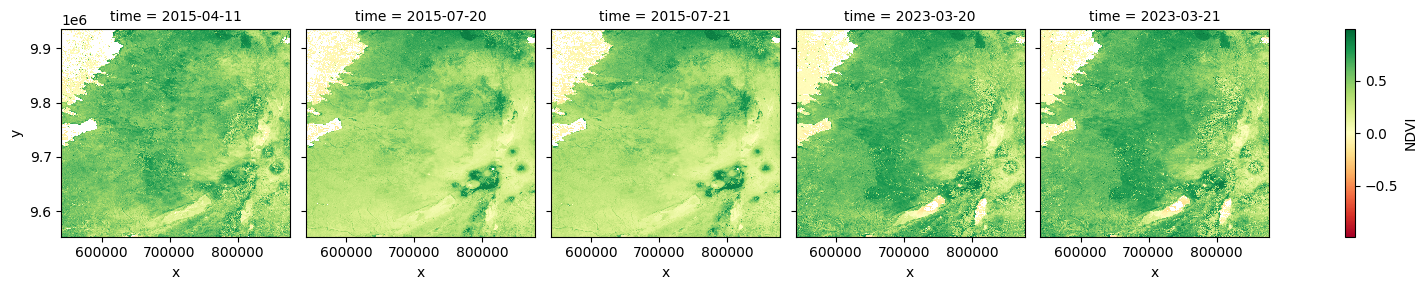

In [8]:
ds.NDVI.isel(time = [100,200,201,3000,3001]).plot(col='time',col_wrap = 5, cmap='RdYlGn')

100%|██████████| 59/59 [02:56<00:00,  2.99s/it]


Epoch 1/100
50/50 [==============================] - 20s 375ms/step - loss: -0.0389 - val_loss: -0.0118
Epoch 2/100
50/50 [==============================] - 22s 447ms/step - loss: -0.0423 - val_loss: -0.0189
Epoch 3/100
50/50 [==============================] - 25s 501ms/step - loss: -0.0433 - val_loss: -0.0072
Epoch 4/100
50/50 [==============================] - 26s 528ms/step - loss: -0.0423 - val_loss: -0.0197
Epoch 5/100
50/50 [==============================] - 28s 556ms/step - loss: -0.0440 - val_loss: -0.0222
Epoch 6/100
50/50 [==============================] - 25s 497ms/step - loss: -0.0453 - val_loss: -0.0259
Epoch 7/100
50/50 [==============================] - 14s 274ms/step - loss: -0.0476 - val_loss: -0.0253
Epoch 8/100
50/50 [==============================] - 13s 252ms/step - loss: -0.0498 - val_loss: -0.0351
Epoch 9/100
50/50 [==============================] - 14s 273ms/step - loss: -0.0507 - val_loss: -0.0219
Epoch 10/100
50/50 [==============================] - 13s 268ms/

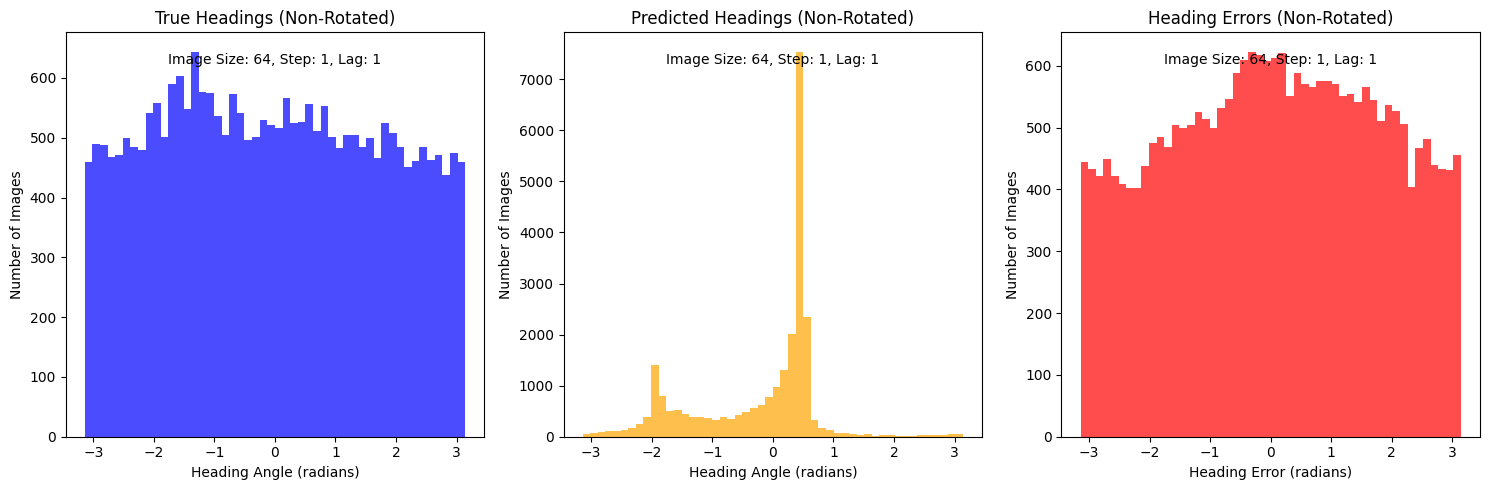

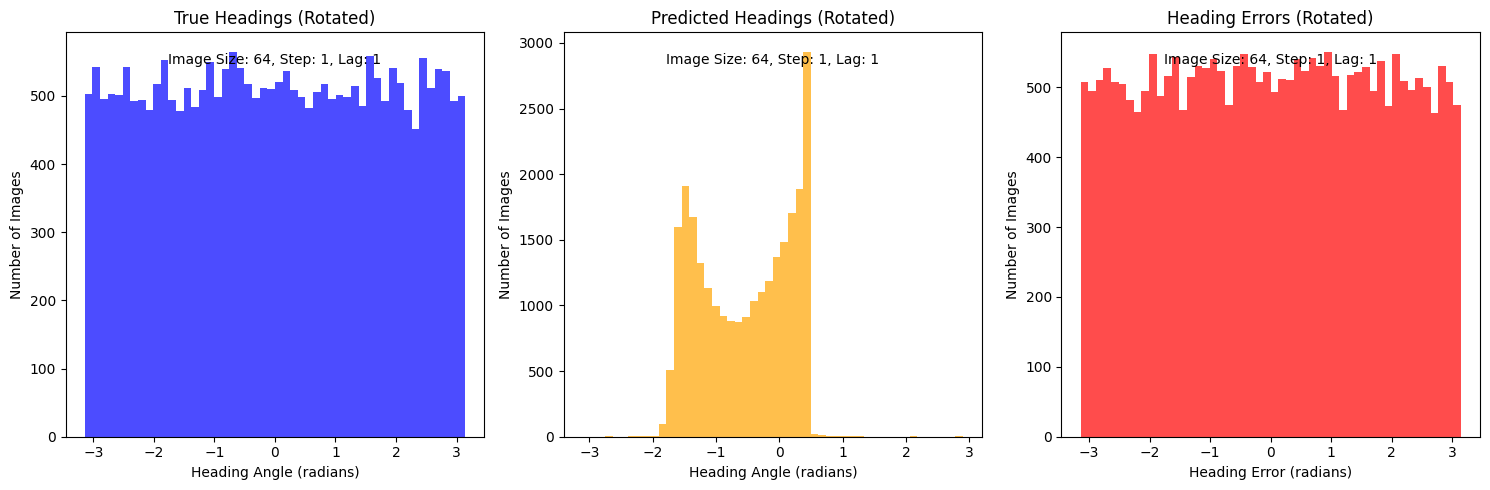

100%|██████████| 59/59 [05:31<00:00,  5.62s/it]


Epoch 1/100
50/50 [==============================] - 16s 302ms/step - loss: -0.0407 - val_loss: -0.0092
Epoch 2/100
50/50 [==============================] - 15s 303ms/step - loss: -0.0423 - val_loss: -0.0137
Epoch 3/100
50/50 [==============================] - 15s 302ms/step - loss: -0.0426 - val_loss: -0.0111
Epoch 4/100
50/50 [==============================] - 14s 289ms/step - loss: -0.0431 - val_loss: -0.0177
Epoch 5/100
50/50 [==============================] - 14s 289ms/step - loss: -0.0435 - val_loss: -0.0149
Epoch 6/100
50/50 [==============================] - 15s 301ms/step - loss: -0.0451 - val_loss: -0.0150
Epoch 7/100
50/50 [==============================] - 18s 359ms/step - loss: -0.0462 - val_loss: -0.0245
Epoch 8/100
50/50 [==============================] - 14s 282ms/step - loss: -0.0389 - val_loss: -0.0219
Epoch 9/100
50/50 [==============================] - 14s 288ms/step - loss: -0.0490 - val_loss: -0.0319
Epoch 10/100
50/50 [==============================] - 15s 300ms/

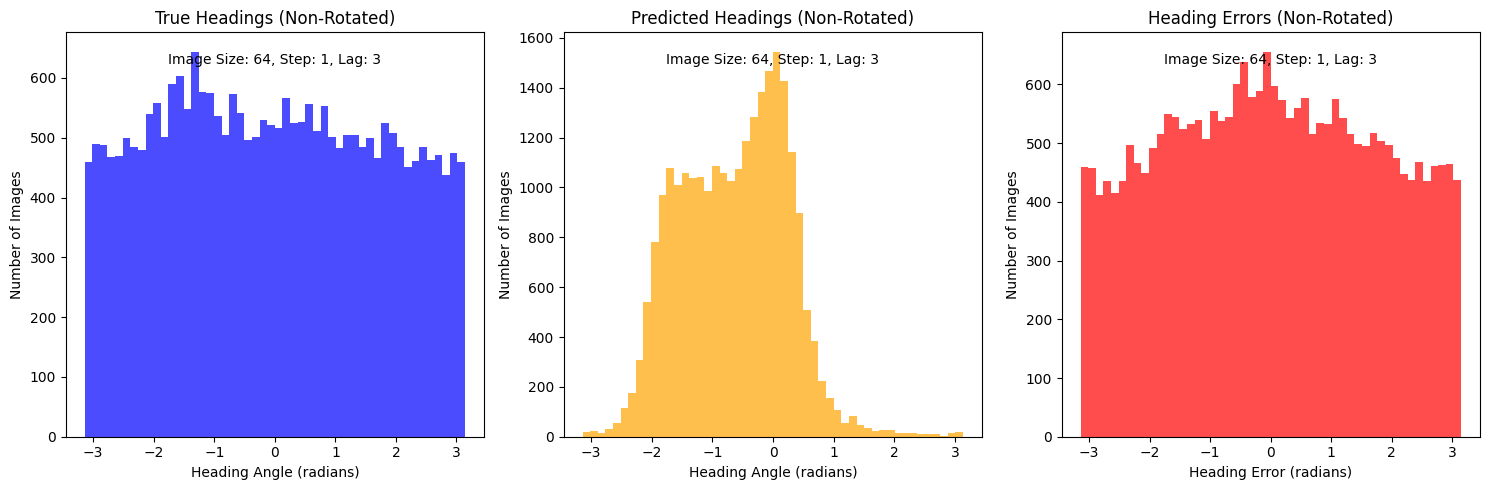

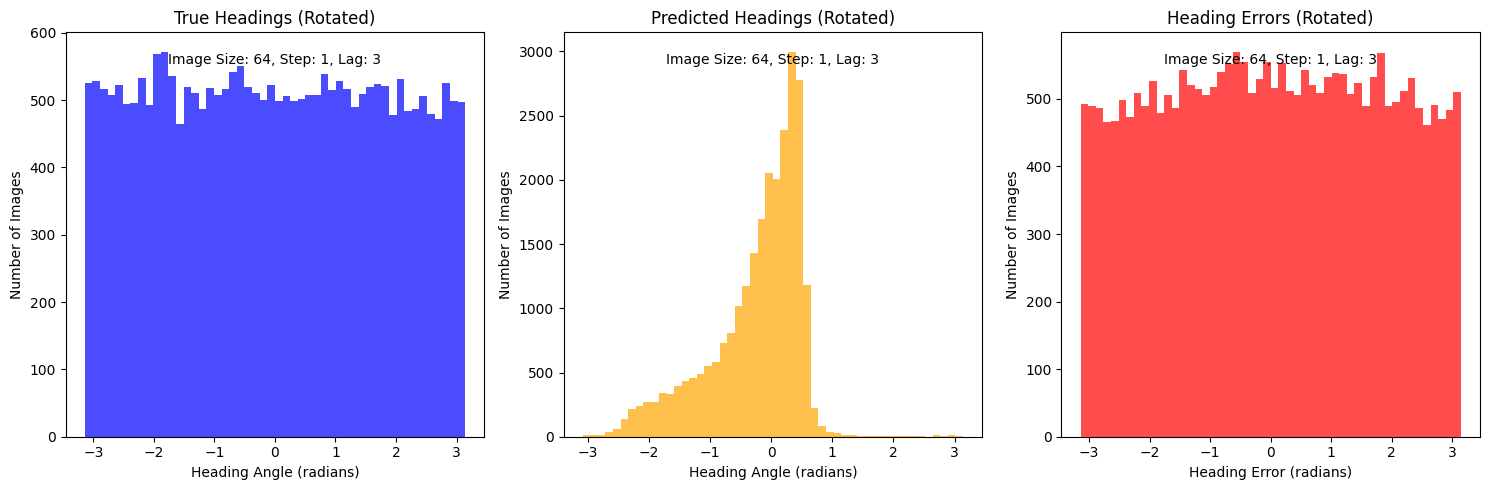

100%|██████████| 59/59 [05:49<00:00,  5.93s/it]


Epoch 1/100
50/50 [==============================] - 19s 357ms/step - loss: -0.0422 - val_loss: -0.0193
Epoch 2/100
50/50 [==============================] - 17s 345ms/step - loss: -0.0426 - val_loss: -0.0159
Epoch 3/100
50/50 [==============================] - 17s 343ms/step - loss: -0.0420 - val_loss: -0.0148
Epoch 4/100
50/50 [==============================] - 17s 332ms/step - loss: -0.0426 - val_loss: -0.0180
Epoch 5/100
50/50 [==============================] - 17s 335ms/step - loss: -0.0431 - val_loss: -0.0151
Epoch 6/100
50/50 [==============================] - 17s 338ms/step - loss: -0.0446 - val_loss: -0.0193
Epoch 7/100
50/50 [==============================] - 17s 346ms/step - loss: -0.0494 - val_loss: -0.0074
Epoch 8/100
50/50 [==============================] - 17s 346ms/step - loss: -0.0521 - val_loss: -0.0293
Epoch 9/100
50/50 [==============================] - 17s 346ms/step - loss: -0.0478 - val_loss: -0.0091
Epoch 10/100
50/50 [==============================] - 17s 339ms/

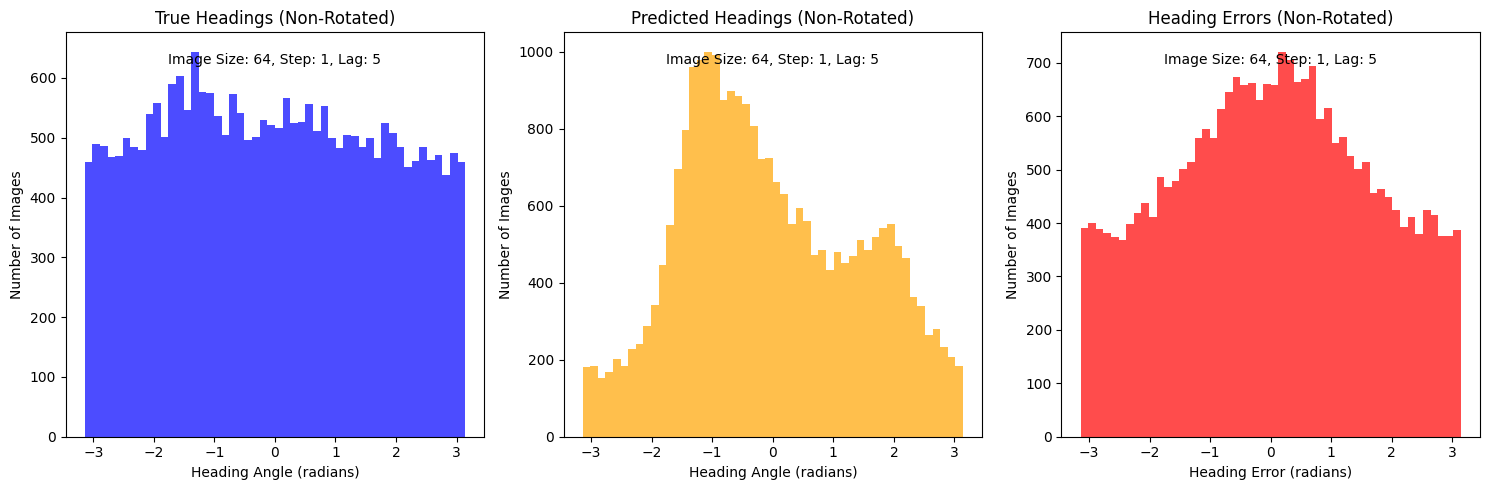

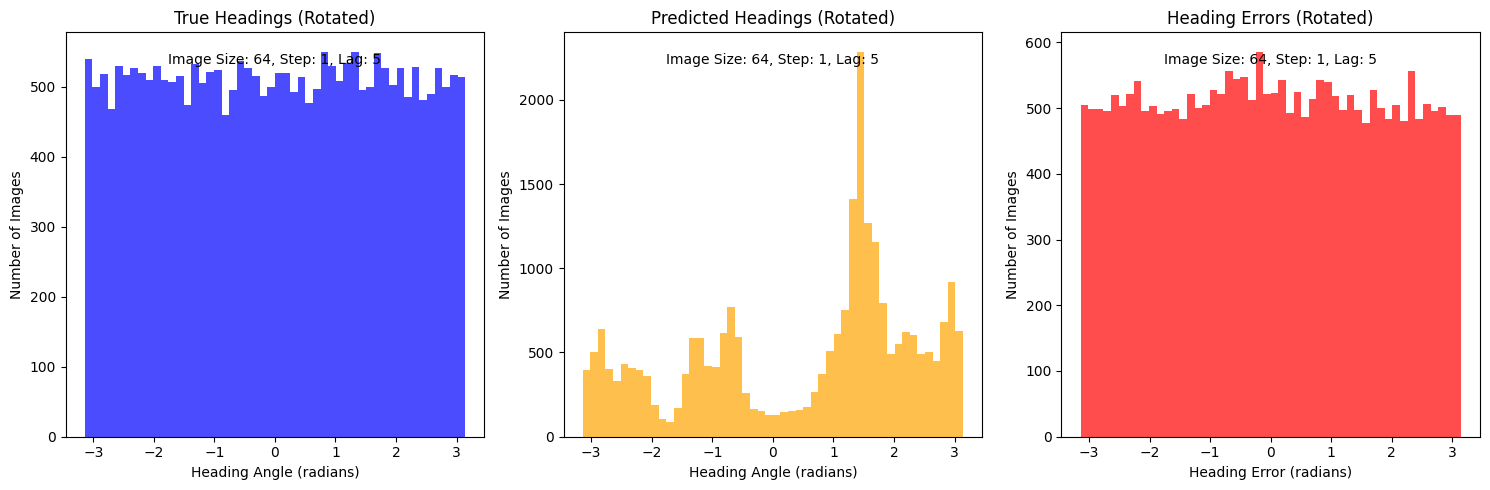

100%|██████████| 59/59 [07:02<00:00,  7.15s/it]


Epoch 1/100
50/50 [==============================] - 22s 409ms/step - loss: -0.0402 - val_loss: -0.0085
Epoch 2/100
50/50 [==============================] - 19s 385ms/step - loss: -0.0421 - val_loss: -0.0069
Epoch 3/100
50/50 [==============================] - 36s 729ms/step - loss: -0.0429 - val_loss: -0.0181
Epoch 4/100
50/50 [==============================] - 30s 590ms/step - loss: -0.0436 - val_loss: -0.0107
Epoch 5/100
50/50 [==============================] - 19s 383ms/step - loss: -0.0415 - val_loss: -0.0222
Epoch 6/100
50/50 [==============================] - 19s 378ms/step - loss: -0.0451 - val_loss: -0.0232
Epoch 7/100
50/50 [==============================] - 19s 378ms/step - loss: -0.0484 - val_loss: -0.0262
Epoch 8/100
50/50 [==============================] - 19s 379ms/step - loss: -0.0527 - val_loss: -0.0155
Epoch 9/100
50/50 [==============================] - 19s 378ms/step - loss: -0.0566 - val_loss: -0.0328
Epoch 10/100
50/50 [==============================] - 19s 379ms/

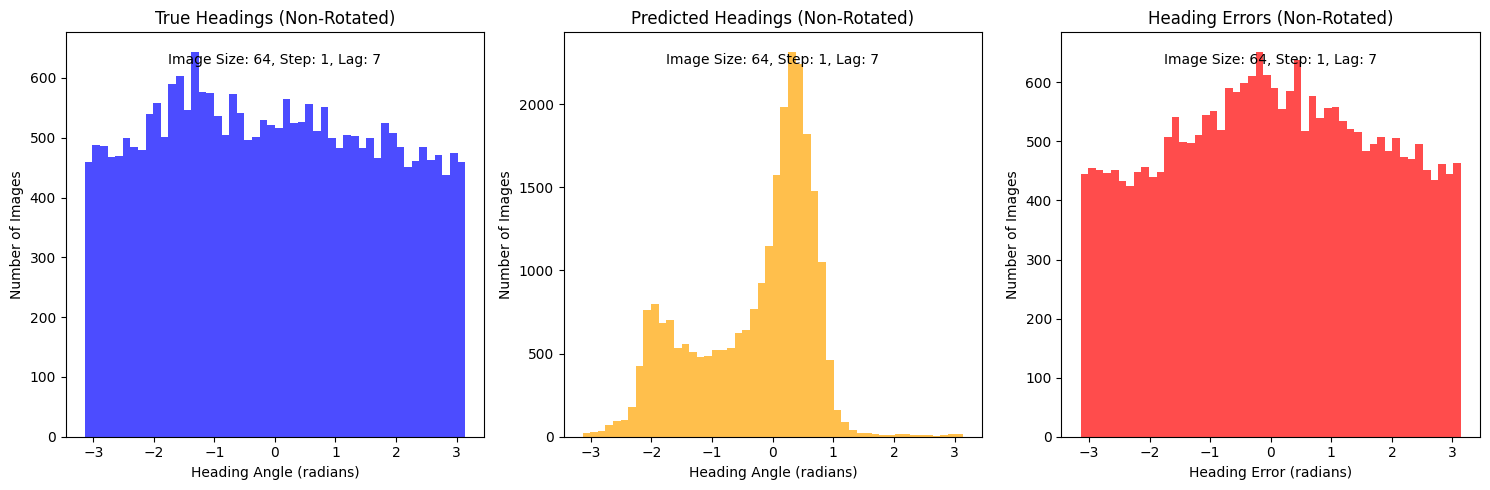

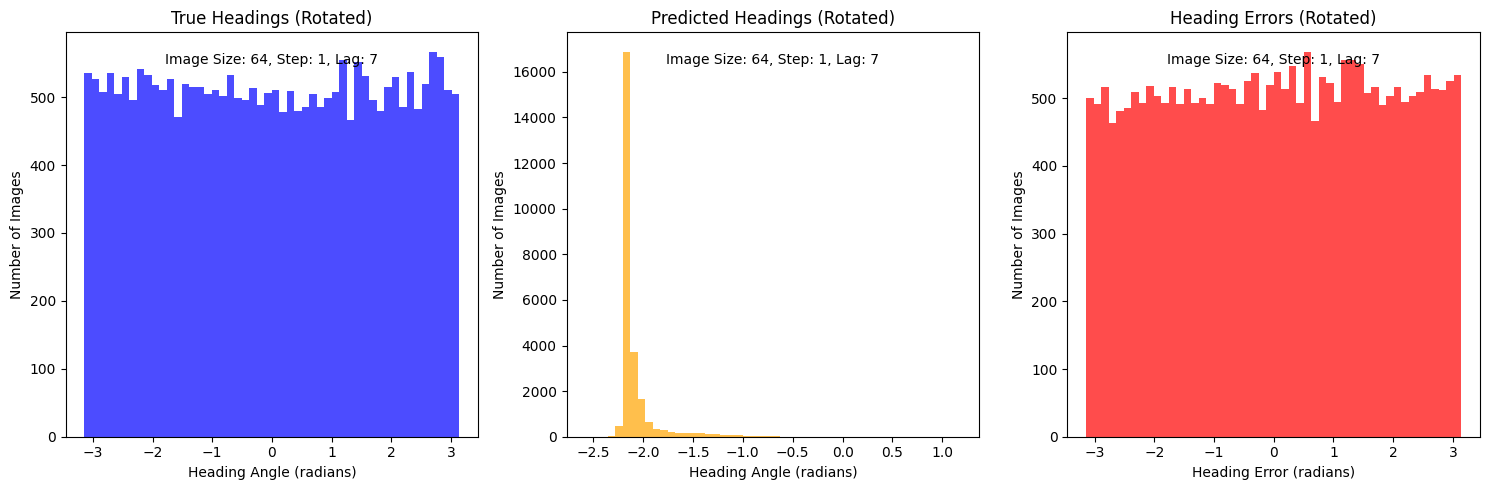

100%|██████████| 59/59 [06:47<00:00,  6.91s/it]


Epoch 1/100
50/50 [==============================] - 22s 422ms/step - loss: -0.0410 - val_loss: -0.0167
Epoch 2/100
50/50 [==============================] - 20s 400ms/step - loss: -0.0433 - val_loss: -0.0155
Epoch 3/100
50/50 [==============================] - 20s 405ms/step - loss: -0.0436 - val_loss: -0.0140
Epoch 4/100
50/50 [==============================] - 20s 404ms/step - loss: -0.0485 - val_loss: -0.0314
Epoch 5/100
50/50 [==============================] - 20s 402ms/step - loss: -0.0413 - val_loss: -0.0149
Epoch 6/100
50/50 [==============================] - 20s 401ms/step - loss: -0.0487 - val_loss: -0.0216
Epoch 7/100
50/50 [==============================] - 20s 401ms/step - loss: -0.0489 - val_loss: -0.0140
Epoch 8/100
50/50 [==============================] - 20s 398ms/step - loss: -0.0474 - val_loss: -0.0012
Epoch 9/100
50/50 [==============================] - 20s 397ms/step - loss: -0.0521 - val_loss: -0.0294
Epoch 10/100
50/50 [==============================] - 20s 394ms/

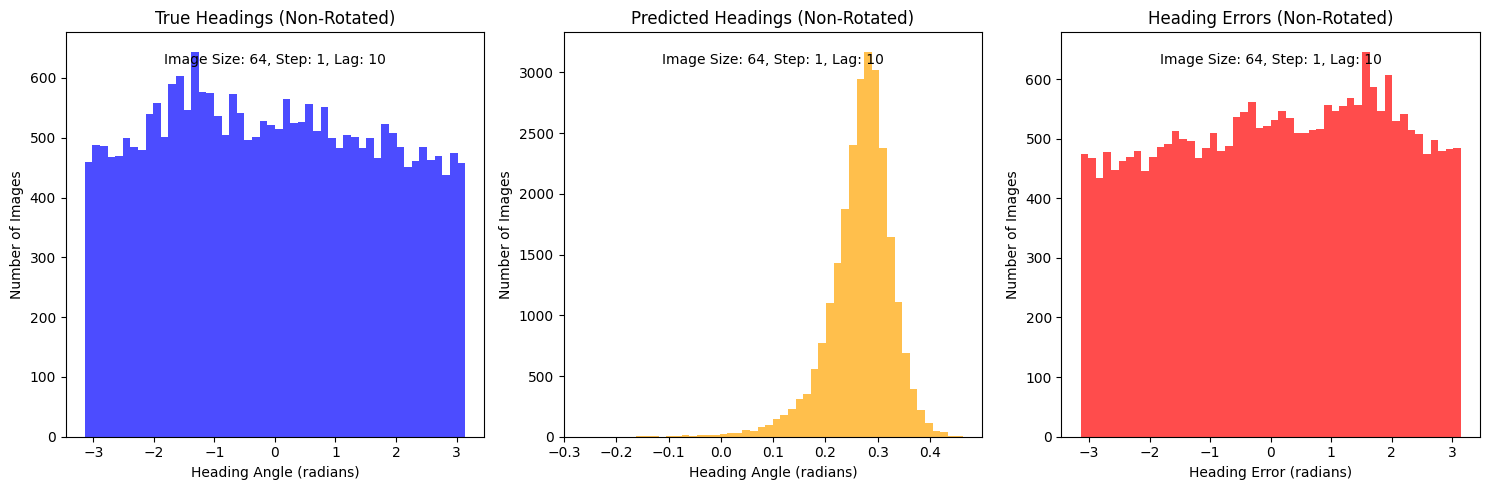

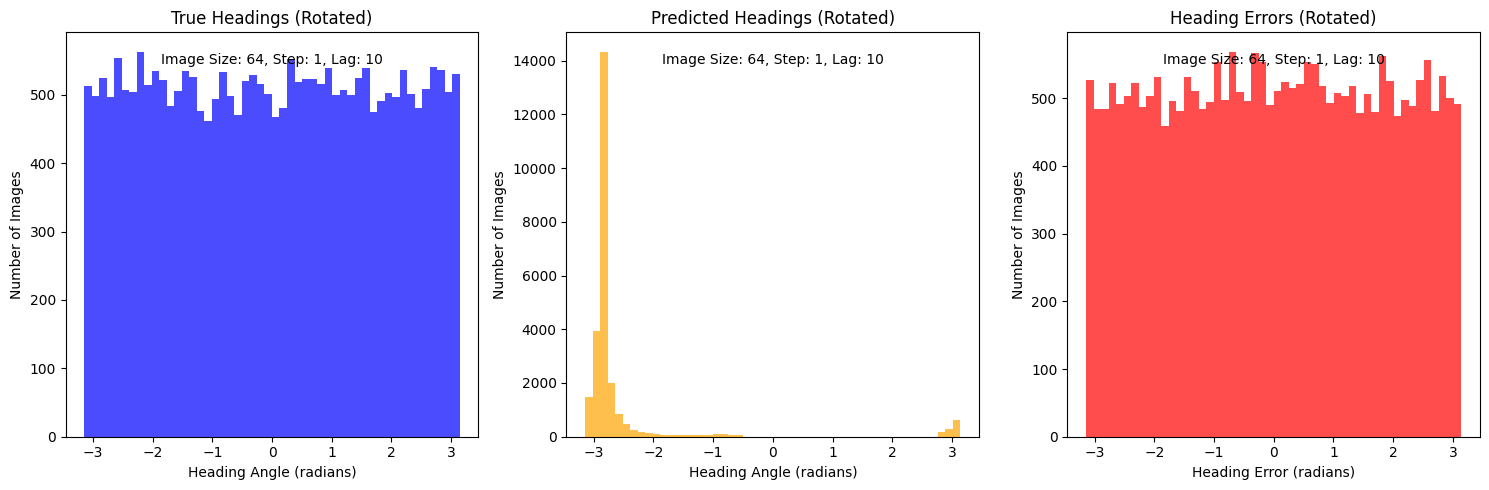

100%|██████████| 59/59 [04:50<00:00,  4.93s/it]


Epoch 1/100
49/49 [==============================] - 14s 258ms/step - loss: -0.0482 - val_loss: -0.0238
Epoch 2/100
49/49 [==============================] - 12s 252ms/step - loss: -0.0523 - val_loss: -0.0274
Epoch 3/100
49/49 [==============================] - 13s 264ms/step - loss: -0.0529 - val_loss: -0.0181
Epoch 4/100
49/49 [==============================] - 12s 244ms/step - loss: -0.0539 - val_loss: -0.0458
Epoch 5/100
49/49 [==============================] - 13s 261ms/step - loss: -0.0533 - val_loss: -0.0425
Epoch 6/100
49/49 [==============================] - 13s 257ms/step - loss: -0.0589 - val_loss: -0.0348
Epoch 7/100
49/49 [==============================] - 12s 248ms/step - loss: -0.0626 - val_loss: -0.0406
Epoch 8/100
49/49 [==============================] - 13s 267ms/step - loss: -0.0677 - val_loss: -0.0800
Epoch 9/100
49/49 [==============================] - 12s 248ms/step - loss: -0.0735 - val_loss: -0.0430
Epoch 10/100
49/49 [==============================] - 13s 257ms/

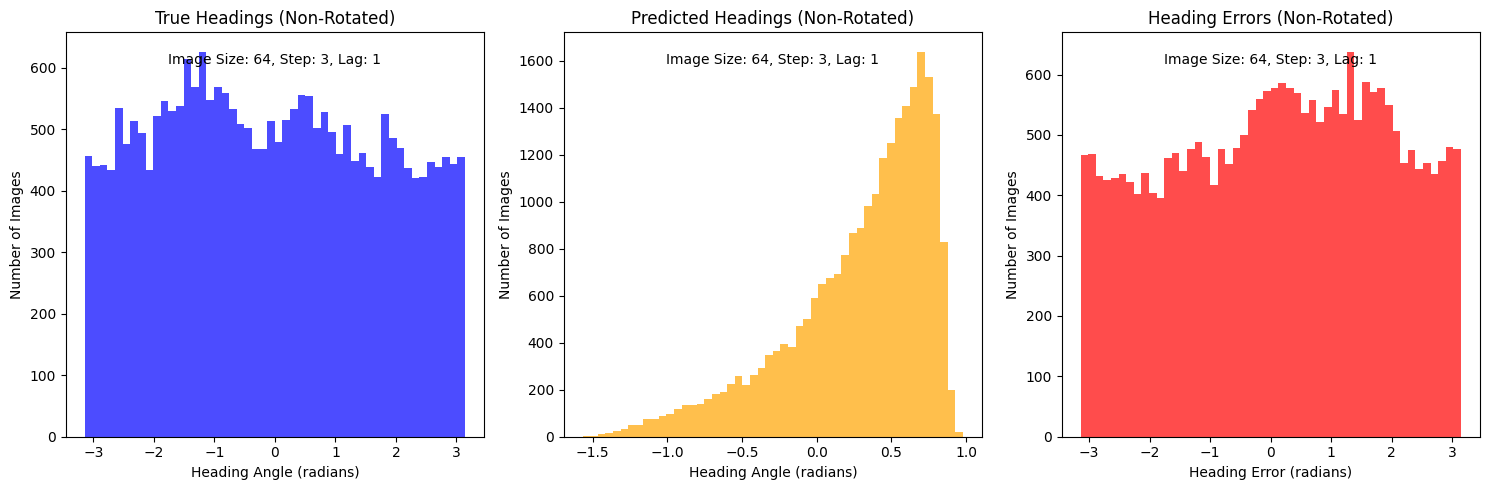

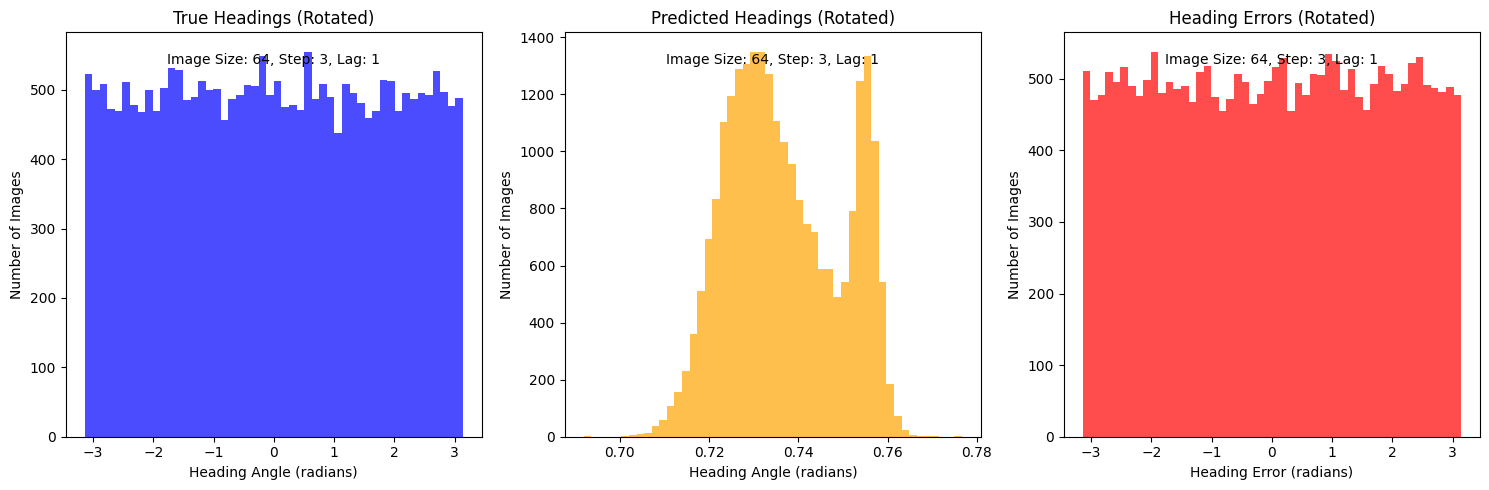

100%|██████████| 59/59 [04:15<00:00,  4.32s/it]


Epoch 1/100
49/49 [==============================] - 16s 306ms/step - loss: -0.0509 - val_loss: -0.0214
Epoch 2/100
49/49 [==============================] - 14s 288ms/step - loss: -0.0513 - val_loss: -0.0262
Epoch 3/100
49/49 [==============================] - 15s 300ms/step - loss: -0.0523 - val_loss: -0.0262
Epoch 4/100
49/49 [==============================] - 15s 306ms/step - loss: -0.0536 - val_loss: -0.0123
Epoch 5/100
49/49 [==============================] - 14s 292ms/step - loss: -0.0545 - val_loss: -0.0225
Epoch 6/100
49/49 [==============================] - 14s 289ms/step - loss: -0.0572 - val_loss: -0.0424
Epoch 7/100
49/49 [==============================] - 15s 304ms/step - loss: -0.0603 - val_loss: -0.0428
Epoch 8/100
49/49 [==============================] - 14s 295ms/step - loss: -0.0648 - val_loss: -0.0514
Epoch 9/100
49/49 [==============================] - 14s 285ms/step - loss: -0.0657 - val_loss: -0.0370
Epoch 10/100
49/49 [==============================] - 15s 297ms/

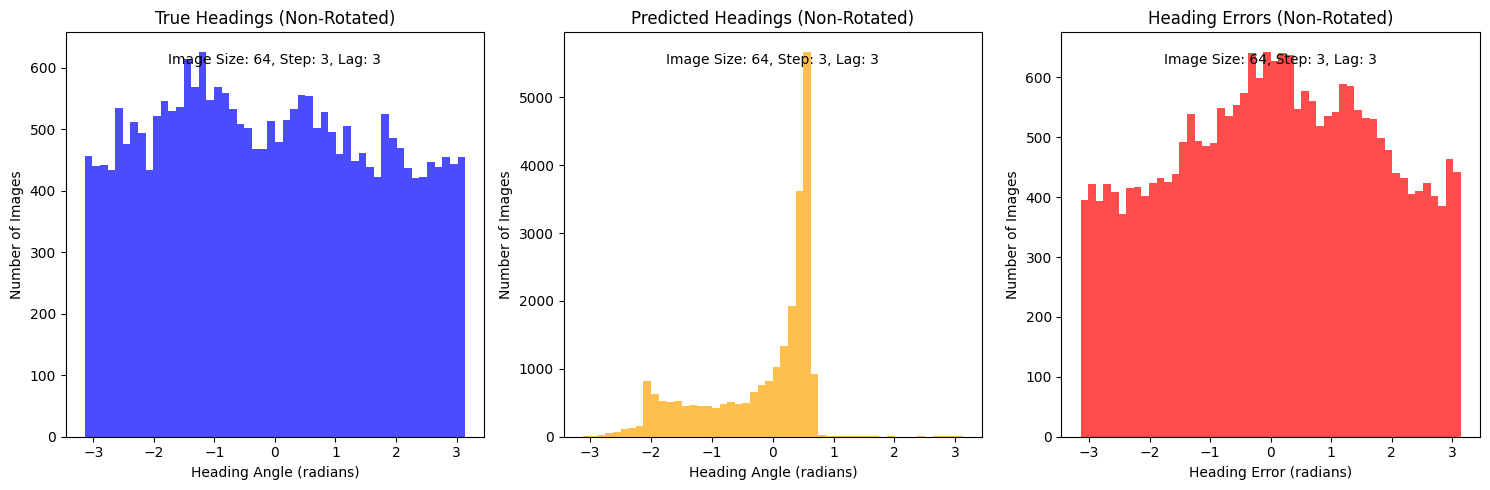

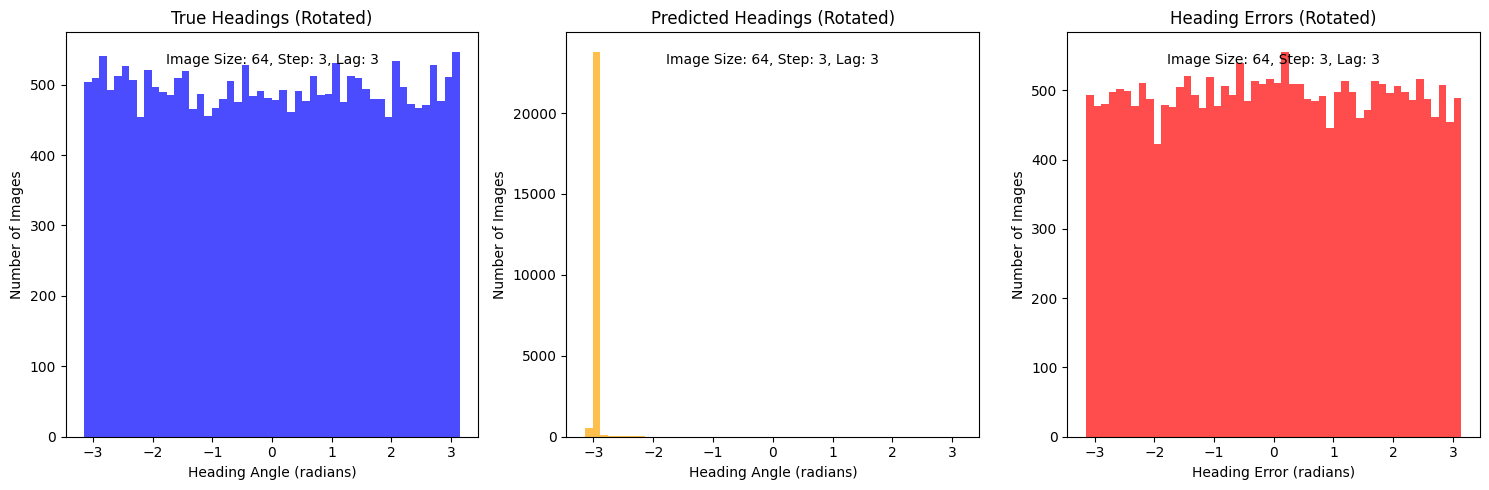

100%|██████████| 59/59 [04:04<00:00,  4.14s/it]


Epoch 1/100
49/49 [==============================] - 18s 344ms/step - loss: -0.0403 - val_loss: -0.0212
Epoch 2/100
49/49 [==============================] - 16s 329ms/step - loss: -0.0522 - val_loss: -0.0186
Epoch 3/100
49/49 [==============================] - 16s 333ms/step - loss: -0.0553 - val_loss: -0.0089
Epoch 4/100
49/49 [==============================] - 17s 341ms/step - loss: -0.0551 - val_loss: -0.0343
Epoch 5/100
49/49 [==============================] - 17s 346ms/step - loss: -0.0569 - val_loss: -0.0348
Epoch 6/100
49/49 [==============================] - 17s 339ms/step - loss: -0.0616 - val_loss: -0.0391
Epoch 7/100
49/49 [==============================] - 19s 396ms/step - loss: -0.0628 - val_loss: -0.0082
Epoch 8/100
49/49 [==============================] - 16s 334ms/step - loss: -0.0669 - val_loss: -0.0102
Epoch 9/100
49/49 [==============================] - 17s 340ms/step - loss: -0.0674 - val_loss: -0.0151
Epoch 10/100
49/49 [==============================] - 17s 347ms/

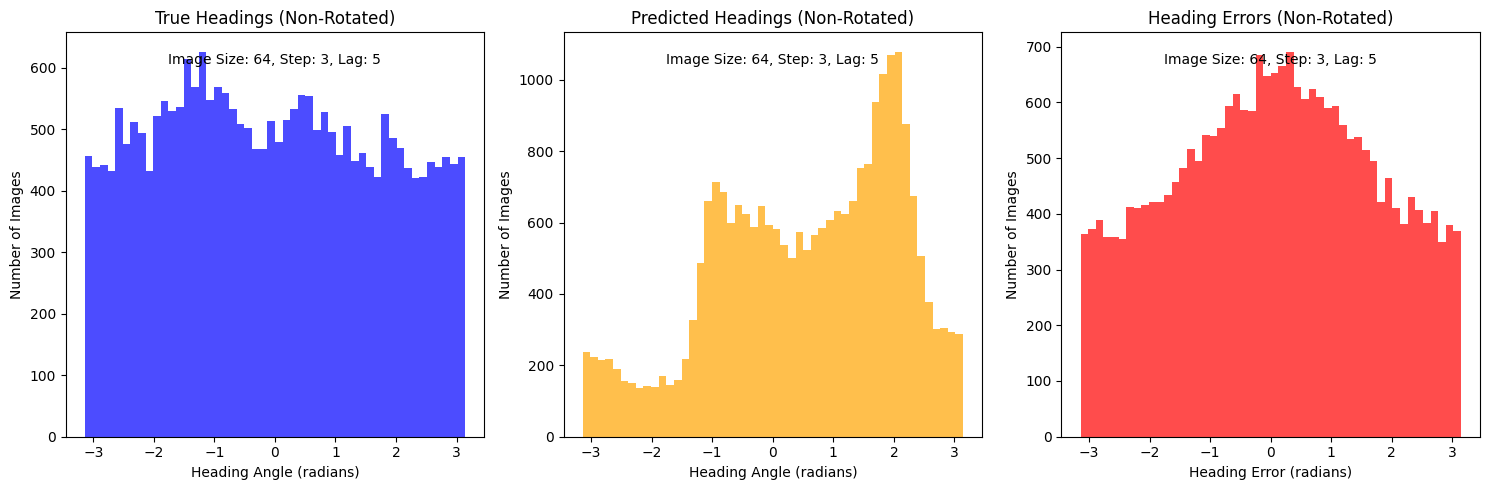

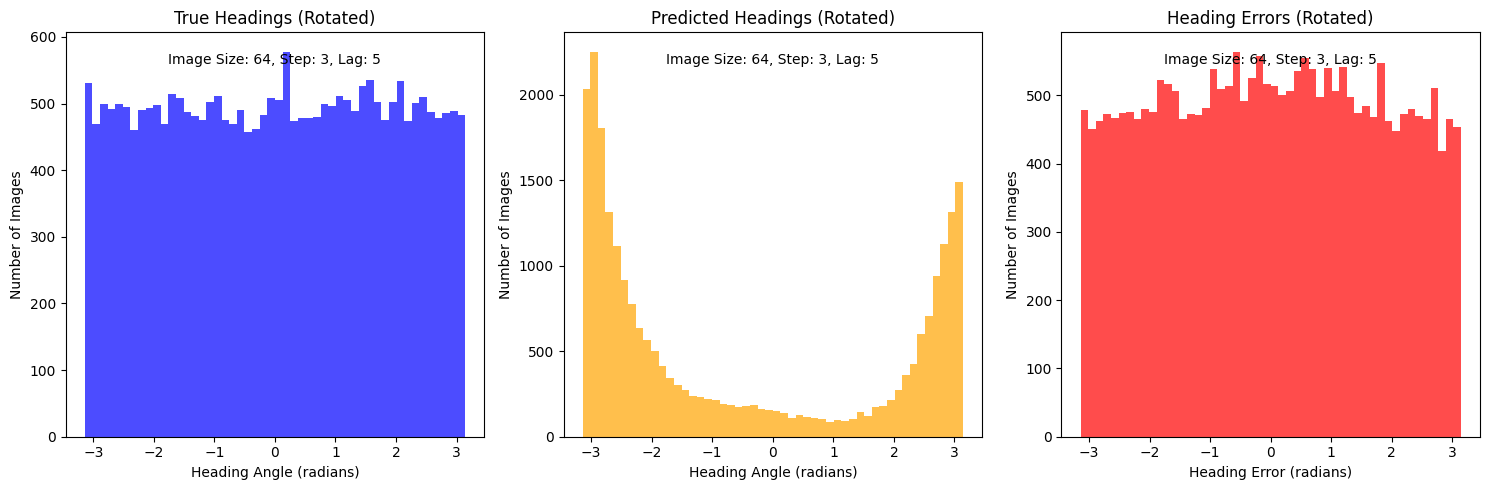

100%|██████████| 59/59 [05:38<00:00,  5.73s/it]


Epoch 1/100
49/49 [==============================] - 20s 391ms/step - loss: -0.0498 - val_loss: -0.0180
Epoch 2/100
49/49 [==============================] - 18s 371ms/step - loss: -0.0519 - val_loss: -0.0275
Epoch 3/100
49/49 [==============================] - 18s 376ms/step - loss: -0.0528 - val_loss: -0.0226
Epoch 4/100
49/49 [==============================] - 19s 378ms/step - loss: -0.0545 - val_loss: 0.0262
Epoch 5/100
49/49 [==============================] - 18s 378ms/step - loss: -0.0432 - val_loss: -0.0234
Epoch 6/100
49/49 [==============================] - 18s 378ms/step - loss: -0.0535 - val_loss: -0.0241
Epoch 7/100
49/49 [==============================] - 19s 380ms/step - loss: -0.0534 - val_loss: -0.0321
Epoch 8/100
49/49 [==============================] - 19s 380ms/step - loss: -0.0367 - val_loss: -0.0172
Epoch 9/100
49/49 [==============================] - 19s 379ms/step - loss: -0.0532 - val_loss: -0.0266
Epoch 10/100
49/49 [==============================] - 18s 374ms/s

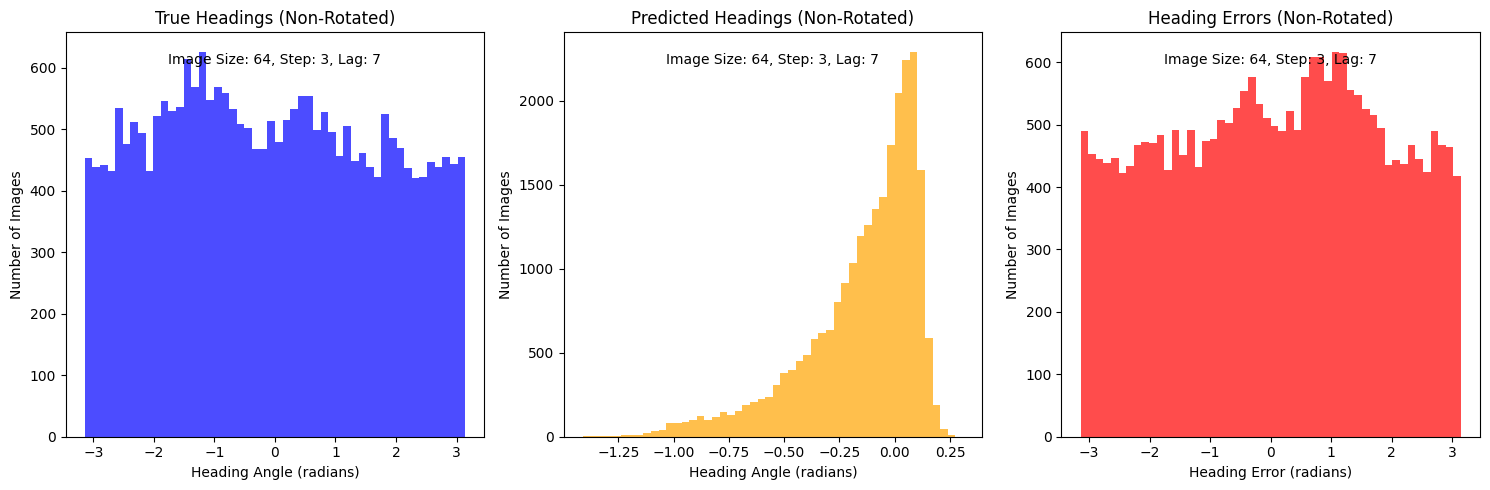

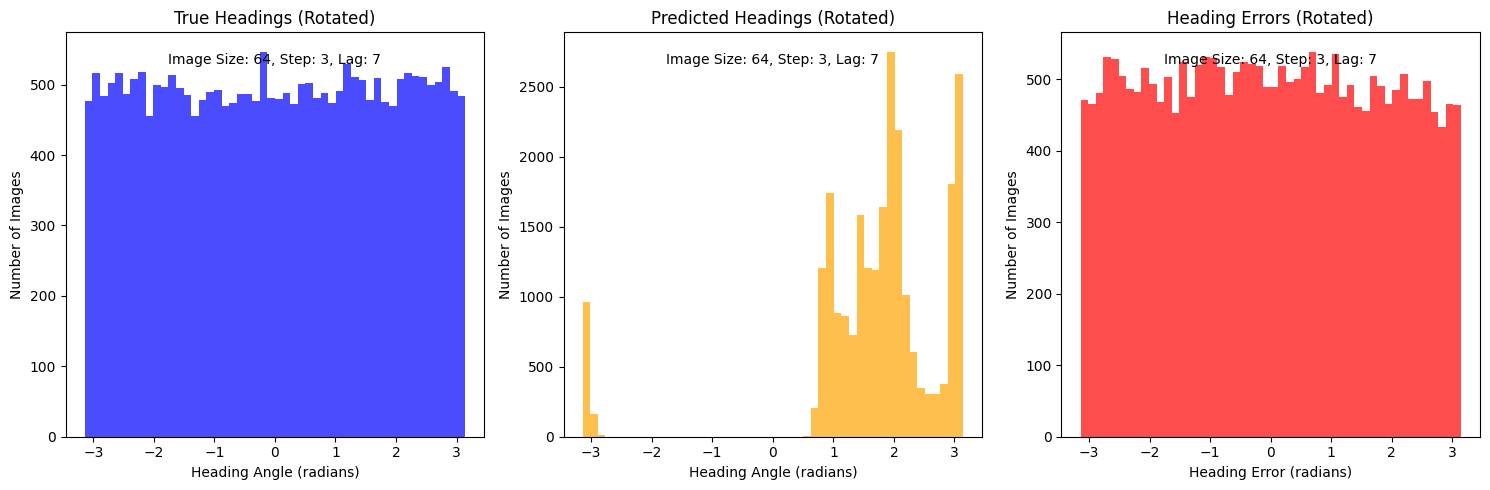

100%|██████████| 59/59 [04:48<00:00,  4.90s/it]


Epoch 1/100
49/49 [==============================] - 22s 424ms/step - loss: -0.0232 - val_loss: -0.0236
Epoch 2/100
49/49 [==============================] - 19s 395ms/step - loss: -0.0515 - val_loss: -0.0251
Epoch 3/100
49/49 [==============================] - 19s 395ms/step - loss: -0.0519 - val_loss: -0.0201
Epoch 4/100
49/49 [==============================] - 20s 401ms/step - loss: -0.0520 - val_loss: -0.0238
Epoch 5/100
49/49 [==============================] - 19s 396ms/step - loss: -0.0522 - val_loss: -0.0255
Epoch 6/100
49/49 [==============================] - 20s 401ms/step - loss: -0.0519 - val_loss: -0.0259
Epoch 7/100
49/49 [==============================] - 19s 396ms/step - loss: -0.0572 - val_loss: -0.0221
Epoch 8/100
49/49 [==============================] - 19s 398ms/step - loss: -0.0528 - val_loss: -0.0260
Epoch 9/100
49/49 [==============================] - 24s 502ms/step - loss: -0.0529 - val_loss: -0.0230
Epoch 10/100
49/49 [==============================] - 23s 466ms/

In [ ]:
# Define lists of parameters to loop over
image_sizes = [64, 128, 256]
steps = [1, 3, 5, 7, 10]
lags = [1, 3, 5, 7, 10]

# Loop over parameter combinations
for image_size in image_sizes:
    for step in steps:
        for lag in lags:
            # Train and visualize results for non-rotated and rotated images
            results = train_and_visualize(gps_data, ds, 2018, image_size, step, lag)
            for result in results:
                label, true_angles, predicted_angles, heading_errors = result

                # Visualize results
                plt.figure(figsize=(15, 5))

                # Visualize true headings
                plt.subplot(1, 3, 1)
                plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
                plt.title(f'True Headings ({label})')
                plt.xlabel('Heading Angle (radians)')
                plt.ylabel('Number of Images')
                plt.text(0.5, 0.95, f"Image Size: {image_size}, Step: {step}, Lag: {lag}",
                         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)

                # Visualize predicted headings
                plt.subplot(1, 3, 2)
                plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
                plt.title(f'Predicted Headings ({label})')
                plt.xlabel('Heading Angle (radians)')
                plt.ylabel('Number of Images')
                plt.text(0.5, 0.95, f"Image Size: {image_size}, Step: {step}, Lag: {lag}",
                         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)

                # Visualize heading errors
                plt.subplot(1, 3, 3)
                plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
                plt.title(f'Heading Errors ({label})')
                plt.xlabel('Heading Error (radians)')
                plt.ylabel('Number of Images')
                plt.text(0.5, 0.95, f"Image Size: {image_size}, Step: {step}, Lag: {lag}",
                         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)

                plt.tight_layout()
                plt.show()

